## Binary classification for the adult dataset
This script works on the adult dataset: https://archive.ics.uci.edu/ml/datasets/adult. The dataset consists of circa 48k data points and 14 attributes, including two sensitive attributes: (i) sex (gender) and (ii) race. The target variable is binary and its goal is to predict whether an individual's annual income is <=50k or >50k. This script starts with an exploratory data analysis of the dataset and proceeds with a predictive modeling apparoach that is fairness-unaware, aiming at the highest accuracy possible, using pandas and scikit-learn. The followed approach consists of the below steps:
1. Data loading and cleaning
2. Exploratory data analysis
3. Feature pre-processing/engineering
4. Model training and evaluation

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
# inline browser plots for jupyter-notebooks
%matplotlib inline

### 1. Data loading and cleaning
This section takes care of the following:
- Imports the dataset from a csv file
- Identifies na values and removes them
- Applies a transformation to the target column to make it binary {0, 1}
- Prints dataframe info() to summarize

In [2]:
# Import dataset
df = pd.read_csv('adult.csv')
# Find na values formatted as special char '?' 
print('NA values:')
print(df.isin(['?']).sum(axis=0))
# Replace '?' with nan and drop na values 
df['native-country'] = df['native-country'].replace('?',np.nan)
df['workclass'] = df['workclass'].replace('?',np.nan)
df['occupation'] = df['occupation'].replace('?',np.nan)
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True) # reset index
# Create binary {0, 1} target column
df['income_greater_than_50k'] = df['income'].apply(lambda i: 1 if i=='>50K' else 0) # set explainable name
df.drop(columns=['income'], inplace=True) # drop income column
# Print dataframe summary info
print('\nDataset summary:')
print(df.info())

NA values:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

Dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      45222 non-null  int64 
 1   workclass                45222 non-null  object
 2   fnlwgt                   45222 non-null  int64 
 3   education                45222 non-null  object
 4   education-num            45222 non-null  int64 
 5   marital-status           45222 non-null  object
 6   occupation               45222 non-null  object
 7   relationship          

### 2. Exploratory data analysis
This section uses pandas and matplotlib to gain a first insight into the features and their distributions. More specifically it includes:
- Histograms of numerical and categorical features
- Histograms of feature-target distributions displaying the percentage of income >50k (i.e. target=1) for different attribute values. That way we can look for values that have strong correlations with specific target values.

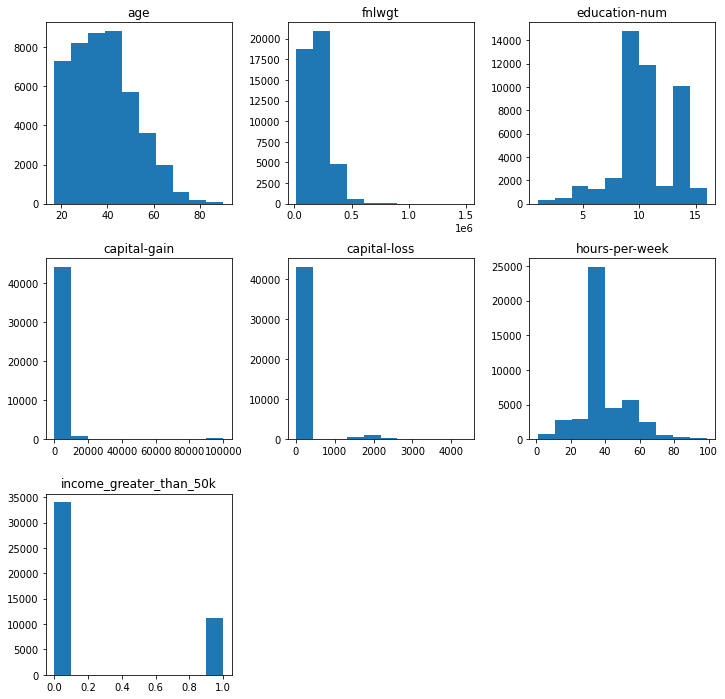

In [3]:
# Histograms of numerical features
#
num_features = [f for f in df.columns if df[f].dtype == np.int64] # numerical features
_ = df.hist(column=num_features, figsize=(12,12), grid=False) # histograms of numerical features

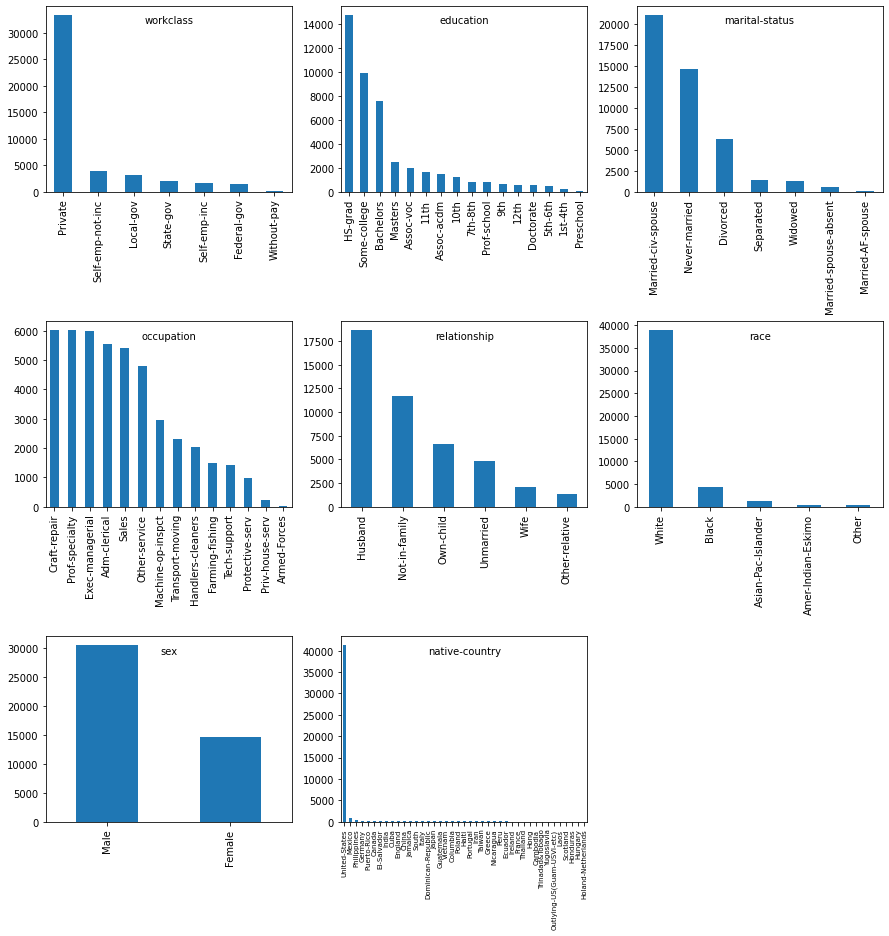

In [4]:
# Histograms of categorical features
#
cat_features = [f for f in df.columns if df[f].dtype == np.object] # categorical features
# Figure properties
num_rows = int(np.ceil(len(cat_features)/3))
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,15)) # [3 x 3] grid
axes[2, 2].set_axis_off() # hide empty plot at location (3,3) in grid
# Construct bar distribution plots
for i in range(len(cat_features)):
    ax = axes[int(np.floor(i/3)), i%3] # axis grid index
    ax.set_xlabel(cat_features[i]) # xlabel name
    if cat_features[i] == 'native-country': # multi-value feature
        ax.tick_params(axis='x', labelsize=7) # reduce xtick label size
    ax.xaxis.set_label_coords(0.5,0.95) # xlabel positioning (top-center)
    df[cat_features[i]].value_counts().plot(ax=ax, kind='bar')
plt.subplots_adjust(hspace=0.7) # set spacing between subplots
plt.show()

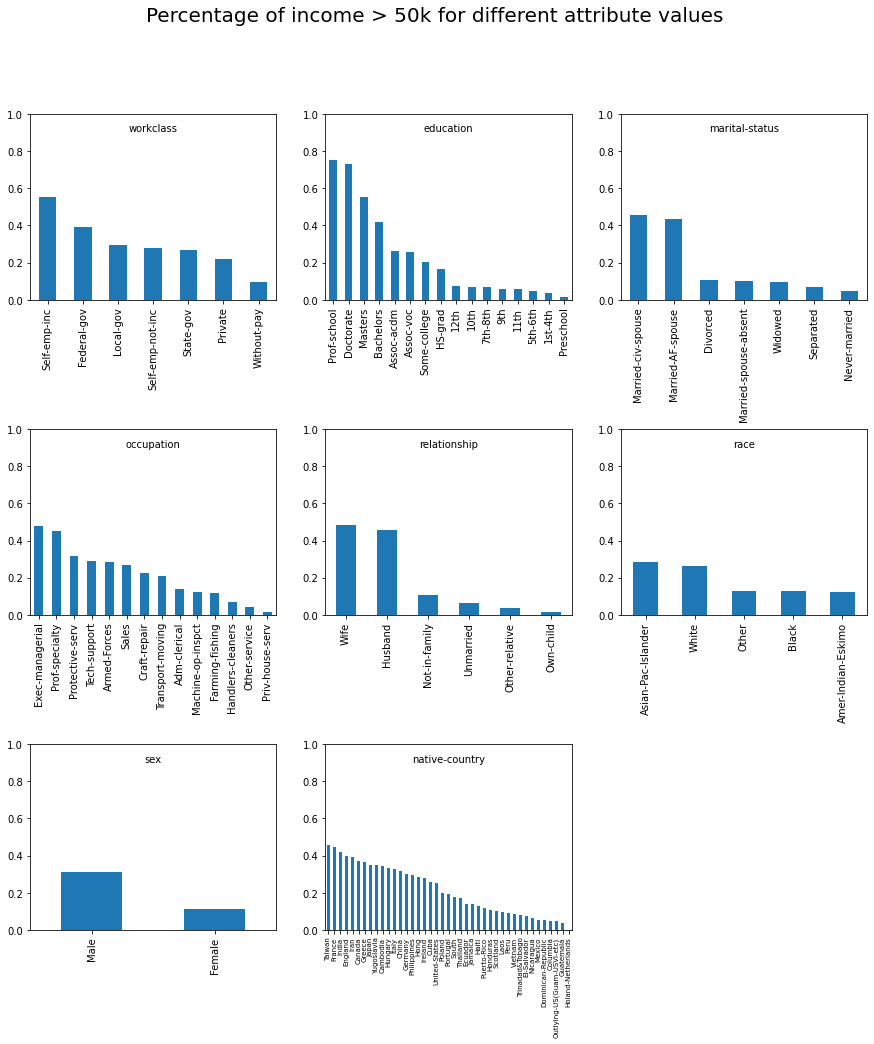

In [5]:
# Feature-target distributions
# Percentage of income >50k for different attribute values
#
# Figure properties
num_rows = int(np.ceil(len(cat_features)/3))
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,15)) # [3 x 3] grid
axes[2, 2].set_axis_off() # hide empty plot at location (3,3) in grid
fig.suptitle('Percentage of income > 50k for different attribute values', fontsize=20) # figure super-title
# Construct bar plots
for i in range(len(cat_features)):
    ax = axes[int(np.floor(i/3)), i%3] # axis grid index
    if cat_features[i] == 'native-country': # multi-value feature
        ax.tick_params(axis='x', labelsize=7) # reduce xtick label size
    ax.xaxis.set_label_coords(0.5,0.95) # xlabel positioning (top-center)
    df.groupby(cat_features[i]).income_greater_than_50k.mean().sort_values(ascending=False).plot(ax=ax, ylim =[0,1], kind='bar')
plt.subplots_adjust(hspace=0.7) # set spacing between subplots
plt.show()

### 3. Feature pre-processing/engineering
This section uses techniques to pre-process and trasnform the original feature set in the following ways:
- Feature encoding: one-hot encoding of categorical features (prefered over ordinal encoding since there is no ordering in these features). That results in a feature set of cardinality n>100.
- Split to training and test sets with a ration of 70%-30%. Due to the large size of the dataset, both cardinalities are considered adequate for a robust model evaluation.
- Feature scaling: either min-max scaling or standardization. Fit only to seen data (train set) and then apply transformation to both train and test (unseen) set.
- Feature selection: select the best k features w.r.t. ANOVA F-value scores. Several experiments were conducted to obtain an optimal number of features. After k=10 the performance does not increase significantly with increased k. The most significant features that are selected are also dispalyed to the user.

In [6]:
# Step 3.1: feature encoding
df = pd.get_dummies(df, columns=cat_features) # one-hot encoding of categorical features
print('Dataframe shape after feature encoding:', df.shape)
# Step 3.2: split to training and test sets
X = df.drop(columns=['income_greater_than_50k']) # feature vector
y = df['income_greater_than_50k'] # target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
# Step 3.3: feature scaling
#scaler = MinMaxScaler() # choose min-max scaling
scaler = StandardScaler() # choose standardization
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Step 3.4: feature selection
k = 10 # num of features to keep
selector = SelectKBest(k=k) # based on ANOVA F-value scores (f_classif)
selector.fit(X_train, y_train) # calculate best features
X_train = selector.transform(X_train) # transform training set
X_test = selector.transform(X_test) # transform test set
# Inspect best k features
cols = selector.get_support(indices=True)
Xk = X.iloc[:,cols] # k-best feature vector
print('Best', k ,'features:\n', list(Xk.columns))
# Print final shapes
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

Dataframe shape after feature encoding: (45222, 105)
Best 10 features:
 ['age', 'education-num', 'capital-gain', 'hours-per-week', 'marital-status_Married-civ-spouse', 'marital-status_Never-married', 'relationship_Husband', 'relationship_Own-child', 'sex_Female', 'sex_Male']
X_train: (31655, 10)
X_test: (13567, 10)


### 4. Model training and evaluation
Experimentation with several classifiers and evaluation of their performance. Although an extended list of classifiers could be used and evaluated thoroughly, for the context of this assignment only the below models were tried and are expected to perform reasonably well:
- Gaussian Naive Bayes
- K-Nearest Neighbors
- Logistic Regression
- Random Forest
- Gradient Boosting

In terms of performance evaluation, the accuracy and the fit times of all models are provided, as well as the confusion matrix of the predictions to facilitate comparisons. Additional metrics (precision, recall, f1 score, misclassification rates etc.) could also be calculated.

In [7]:
# Model definitions
gnb = GaussianNB()
knn = KNeighborsClassifier()
lr = LogisticRegression(solver='newton-cg') # lbfgs solver does not converge, newton-cg supports l2 regularization (default)
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
models = [gnb, knn, lr, rf, gb] # list of all model instances
model_names = ['gnb', 'knn', 'lr', 'rf', 'gb'] # names used for plotting
# Training, prediction, evaluation
accuracies = [] # accuracy scores
f1_scores = [] # f1 scores
times = [] # fit times
for model in models:
    start = time.time() # start ticking
    model.fit(X_train, y_train) # fit
    end = time.time() # stop ticking
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    times.append(end-start)

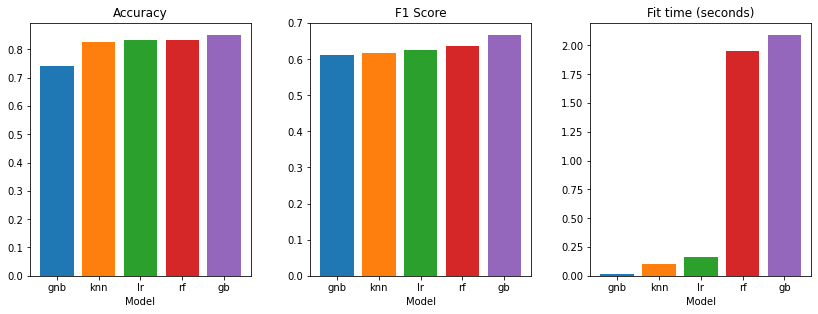

In [8]:
# Visualize results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
color = ['C' + str(i) for i in np.arange(len(accuracies))]
ax1.bar(range(len(accuracies)), accuracies, color=color)
ax1.set(xlabel="Model",title='Accuracy', xticks=np.arange(len(accuracies)), xticklabels=model_names)
ax2.bar(range(len(f1_scores)), f1_scores, color=color)
ax2.set(xlabel="Model",title='F1 Score', xticks=np.arange(len(f1_scores)), xticklabels=model_names)
ax3.bar(range(len(times)), times, color=color)
ax3.set(xlabel="Model",title='Fit time (seconds)', xticks=np.arange(len(times)), xticklabels=model_names)
fig. tight_layout(pad=3.0)
plt.show()